In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
# def mu(x, a, b):
#     return a + b*x

# def generate_data(a, b, n):
#     x = np.random.uniform(-5, 5, n)
#     s = 2
#     y = mu(x, a, b) + s*np.random.randn(n)
#     return np.column_stack((x, y))

# def dist_shift_data(a, b, n):
#     x = 1 + 4*np.random.randn(n)
#     s = 2
#     y = mu(x, a, b) + s*np.random.randn(n)
#     return np.column_stack((x, y))

def mu(x, a, b):
    return a + b*x

# def generate_data(a, b, n):
#     x = np.random.uniform(-5, 5, n)
#     s = (np.abs(x) + 3) * 0.5 * (np.sin(3*x) + 1.5)
#     u = np.random.uniform(0, 1, n)
#     y = mu(x, a, b) + s*np.random.randn(n) + 30 * (u <= 0.02) *np.random.randn(n)
#     return np.column_stack((x, y))

def generate_data(n):
    x = np.random.uniform(-5, 5, n)
    # s = (2*np.abs(x) + 3) * 0.5 * (np.sin(3*x) + 1.5)
    # s = np.abs(x) + 1.5
    s = (2*np.abs(x) + 3) * (np.sin(x)+1.125)
    # y = 1 - x + s*np.random.randn(n) + np.random.beta(5, 2) - (5/7)
    t = 1
    y = 1 - x + (np.random.gamma(0.5*s, t, size=n) - 0.5*s*t)
    return np.column_stack((x, y))

    # y = np.zeros(n)
    # for i in range(1, n+1):
    #     a = (i - n)/(n-1) - 2*((i-1)/(n-1))
    #     b = (n-i)/(n-1) + 3*((i-1)/(n-1))
    #     y[i-1] = mu(x[i-1], a, b) + s*np.random.randn()
    # return np.column_stack((x, y))

In [47]:
n_train, n_cal, n_test = 1500, 3000, 3000
n = n_train + n_cal + n_test
alpha = 0.1

# D_1 = generate_data(1, -1, n_train + n_cal)
# D_2 = dist_shift_data(1, -1, n_test)
# D = np.vstack((D_1, D_2))
# D = generate_data(1, -1, n)
D = generate_data(n)

D_train = D[:n_train,:]
D_cal = D[n_train:(n_train + n_cal),:]
D_test = D[(n_train + n_cal):(n_train + n_cal + n_test),:]

X_train, Y_train = D_train[:, 0], D_train[:, 1]
X_cal, Y_cal = D_cal[:, 0], D_cal[:, 1]
X_test, Y_test = D_test[:, 0], D_test[:, 1]

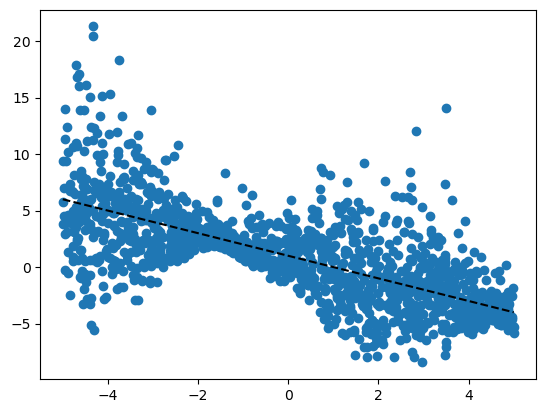

In [48]:
plt.scatter(X_train, Y_train)
plt.plot(X_train[np.argsort(X_train)], 1 - X_train[np.argsort(X_train)], linestyle="dashed", color="black")

In [1]:
# plt.scatter(X_train, Y_train, color="blue")
# plt.scatter(X_cal, Y_cal, color="red")
# plt.scatter(X_test, Y_test, color="orange")

In [49]:
def absolute_residual_score(x, y, model):
    return np.abs(y - model.predict(x).flatten())

def locally_weighted_score(x, y, mu_model, sigma_model):
    return np.abs(y - mu_model.predict(x).flatten())/sigma_model.predict(x).flatten()

# def quantile_score(x, y, model_lower, model_upper, quantiles):
#     pred = model.predict(x, quantiles)
#     l = pred[:, 0].flatten() - y
#     u = y - pred[:, 1].flatten()
#     return np.maximum(l, u)

def check_coverage(alpha, n, y, y_lower, y_upper, q_cal):
    if q_cal >= n+1:
        return 1
    else:
        return np.mean((y <= y_upper) & (y >= y_lower))

q_cal = int(np.ceil((1-alpha)*(n_cal + 1)))

In [50]:
# Split CP with random forests
n_estimators = [100, 150, 200]
max_depth = [5, 10, 15]
min_samples_split = [2, 6, 10]

param_grid = {"n_estimators": n_estimators,
              "max_depth": max_depth,
              "min_samples_split": min_samples_split}

model_RF = GridSearchCV(estimator = RandomForestRegressor(),
                     param_grid= param_grid,
                     cv = 5,
                     n_jobs=4)

model_RF.fit(X_train.reshape(-1, 1), Y_train.ravel())

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 6, 10],
                         'n_estimators': [100, 150, 200]})

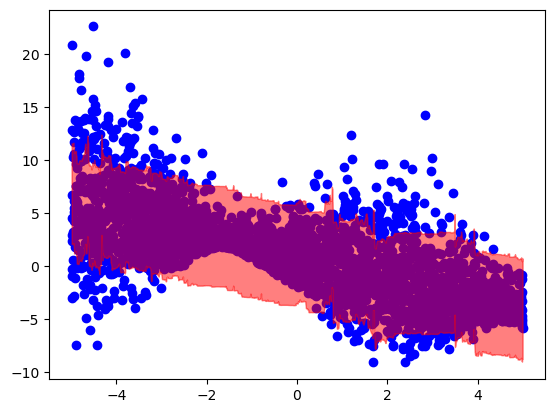

In [51]:
scores_RF = absolute_residual_score(X_cal.reshape(-1, 1), Y_cal, model_RF)

Y_pred_RF = model_RF.predict(X_test.reshape(-1, 1)).flatten()

q_absolute = np.sort(scores_RF.flatten())[q_cal - 1]
y_upper_RF = Y_pred_RF + q_absolute
y_lower_RF = Y_pred_RF - q_absolute

plt.scatter(X_test, Y_test, color="blue")
plt.fill_between(X_test[np.argsort(X_test)], y_lower_RF[np.argsort(X_test)], y_upper_RF[np.argsort(X_test)], color="red", alpha = 0.5)

In [52]:
check_coverage(alpha, n_cal, Y_test, y_lower_RF, y_upper_RF, q_cal)

np.float64(0.8906666666666667)

In [53]:
2*q_absolute

np.float64(9.483054510623422)

In [54]:
abs_errors = absolute_residual_score(X_train.reshape(-1, 1), Y_train, model_RF)

# sigma_regressor =  make_pipeline(StandardScaler(), SVR(kernel='poly', degree=7, C=1, coef0=1))
# sigma_regressor.fit(X_train.reshape(-1, 1), abs_errors.ravel())

sigma_model = GridSearchCV(estimator = RandomForestRegressor(),
                     param_grid= param_grid,
                     cv = 5,
                     n_jobs=4)
sigma_model.fit(X_train.reshape(-1, 1), abs_errors.ravel())

weighted_scores = locally_weighted_score(X_cal.reshape(-1, 1), Y_cal, model_RF, sigma_model)

sigma_pred = sigma_model.predict(X_test.reshape(-1,1)).flatten()

q_weighted = np.sort(weighted_scores.flatten())[q_cal - 1]

y_upper_W = Y_pred_RF + q_weighted * sigma_pred
y_lower_W = Y_pred_RF - q_weighted * sigma_pred

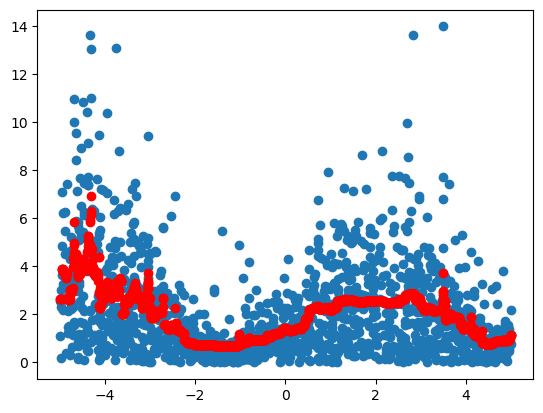

In [55]:
plt.scatter(X_train, abs_errors)
plt.scatter(X_train, sigma_model.predict(X_train.reshape(-1,1)), color="red")

In [130]:
# plt.scatter(X_train, abs_errors, color="blue")
# plt.scatter(X_train, sigma_regressor.predict(X_train.reshape(-1, 1)), color="red")

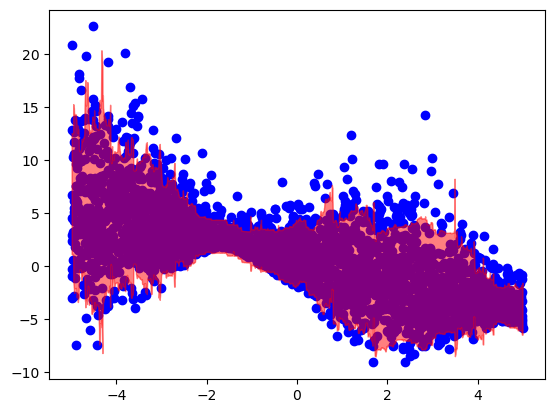

In [56]:
plt.scatter(X_test, Y_test, color="blue")
plt.fill_between(X_test[np.argsort(X_test)], y_lower_W[np.argsort(X_test)], y_upper_W[np.argsort(X_test)], color="red", alpha = 0.5)

In [57]:
check_coverage(alpha, n_cal, Y_test, y_lower_W, y_upper_W, q_cal)

np.float64(0.888)

In [58]:
np.mean(y_upper_W - y_lower_W)

np.float64(8.463223862473358)

In [59]:
from sklearn_quantile import RandomForestQuantileRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer


param_grid = dict(
    n_estimators=[100, 150, 200, 250],
    max_depth=[2, 5, 10, 15, 20],
    min_samples_leaf=[1, 5, 10, 20, 30, 50],
    min_samples_split=[2, 5, 10, 20, 30, 50], 
)
q = 0.05
neg_mean_pinball_loss_05p_scorer = make_scorer(
    mean_pinball_loss,
    alpha=q,
    greater_is_better=False,  # maximize the negative loss
)
qrf = RandomForestQuantileRegressor(q=q)
search_05p = RandomizedSearchCV(
    qrf,
    param_grid,
    n_iter=25,  # increase this if computational budget allows
    scoring=neg_mean_pinball_loss_05p_scorer,
    n_jobs=4,
    random_state=0,
).fit(X_train.reshape(-1,1), Y_train.ravel())

print(search_05p.best_params_)


{'n_estimators': 150, 'min_samples_split': 50, 'min_samples_leaf': 30, 'max_depth': 15}


In [60]:
from sklearn.base import clone

q = 0.95
neg_mean_pinball_loss_95p_scorer = make_scorer(
    mean_pinball_loss,
    alpha=q,
    greater_is_better=False,  # maximize the negative loss
)
search_95p = clone(search_05p).set_params(
    estimator__q=q,
    scoring=neg_mean_pinball_loss_95p_scorer,
)
search_95p.fit(X_train.reshape(-1, 1), Y_train.ravel())
print(search_95p.best_params_)

{'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 5}


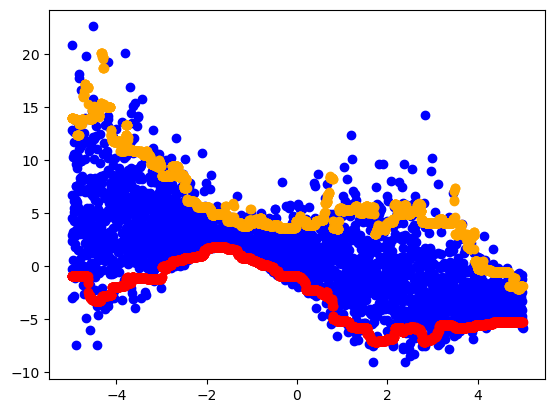

In [61]:
def quantile_score(x, y, lower_q_model, upper_q_model):
    l = lower_q_model.predict(x) - y
    u = y - upper_q_model.predict(x)
    return np.maximum(l, u)

quantile_scores = quantile_score(X_cal.reshape(-1, 1), Y_cal, search_05p, search_95p)
q_quantile = np.sort(quantile_scores.flatten())[q_cal - 1]

Y_lower_pred_Q = search_05p.predict(X_test.reshape(-1, 1))
Y_upper_pred_Q = search_95p.predict(X_test.reshape(-1, 1))
y_lower_Q = Y_lower_pred_Q - q_quantile
y_upper_Q = Y_upper_pred_Q + q_quantile

plt.scatter(X_test, Y_test, color="blue")
plt.scatter(X_test, Y_lower_pred_Q, color="red")
plt.scatter(X_test, Y_upper_pred_Q, color="orange")


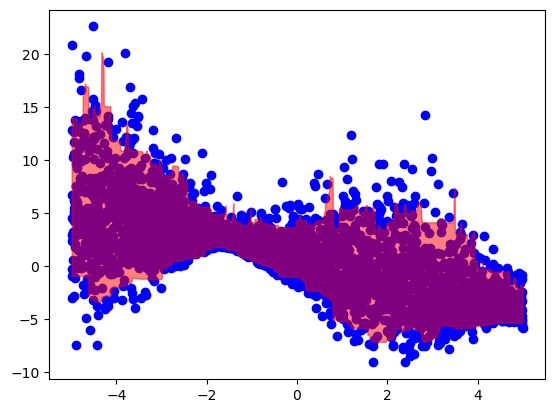

In [62]:
plt.scatter(X_test, Y_test, color="blue")
plt.fill_between(X_test[np.argsort(X_test)], y_lower_Q[np.argsort(X_test)], y_upper_Q[np.argsort(X_test)], color="red", alpha = 0.5)

In [63]:
check_coverage(alpha, n_cal, Y_test, y_lower_Q, y_upper_Q, q_cal)

np.float64(0.8923333333333333)

In [64]:
np.mean(y_upper_Q- y_lower_Q)

np.float64(8.634764565336418)

In [48]:
def get_local_coverage(z, n, q_cal, X, y, y_lower_hat, y_upper_hat):
    if q_cal >= n+1:
        return 1
    else:
        local_cov = np.zeros(len(z)-1)
        for i in range(len(z) - 1):
            idx_local = np.where((X <= z[i+1]) & (X >= z[i]))[0]
            y_local = y[idx_local]
            y_lower_local = y_lower_hat[idx_local]
            y_upper_local = y_upper_hat[idx_local]


            check_lower = (y_local >= y_lower_local)
            check_upper = (y_local <= y_upper_local)


            local_cov[i] = np.mean(check_lower & check_upper)

    return local_cov

In [49]:
width = 1
num = int((16/width)+1)
z = np.linspace(-5, 5, num)

local_cov_split = get_local_coverage(z, n_cal, q_cal, X_test, Y_test, y_lower_RF, y_upper_RF)

local_cov_W = get_local_coverage(z, n_cal, q_cal, X_test, Y_test, y_lower_W, y_upper_W)

local_cov_Q = get_local_coverage(z, n_cal, q_cal, X_test, Y_test, y_lower_Q, y_upper_Q)

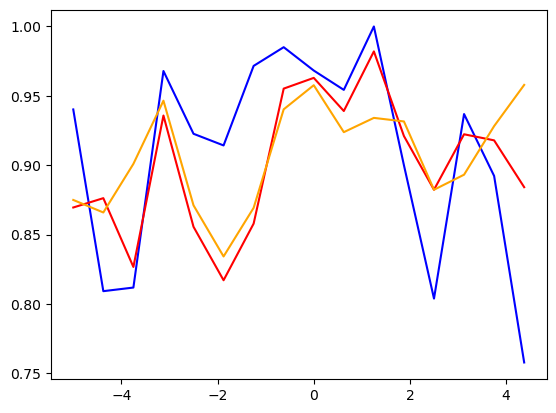

In [50]:
plt.plot(z[:-1], local_cov_split, color="blue")
plt.plot(z[:-1], local_cov_W, color="red")
plt.plot(z[:-1], local_cov_Q, color="orange")

In [ ]:
idx = np.where((X_test <= z[3+1]) & (X_test >= z[3]))[0]
y_local = Y_test[idx]
y_lower_hat = y_lower_RF[idx]
y_upper_hat = y_upper_RF[idx]

check_lower = (y_local >= y_lower_hat)
check_upper = (y_local <= y_upper_hat)

np.mean(check_upper & check_lower)
local_cov_split